# Partie III : Application du machine learning pour la fonction d'évaluation

### Modele KNN

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Charger les fichiers CSV
gagnants = pd.read_csv("dataset_fanorona/fanorona_winning_positions_cleaned.csv", header=None)
perdants = pd.read_csv("dataset_fanorona/fanorona_losing_positions_cleaned.csv", header=None)

# Ajouter la colonne cible (1 pour gagnant, -1 pour perdant)
gagnants["score"] = 1
perdants["score"] = -1

# Fusionner les données
data = pd.concat([gagnants, perdants], ignore_index=True)

# Séparer les features et labels
X = data.iloc[:, :-1].values  # Les configurations de plateau
y = data["score"].values  # Les scores

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")

# Validation croisée
cv_scores = cross_val_score(knn_model, X, y, cv=4, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Précision moyenne : {cv_scores.mean():.2f}")

# Simulation du jeu Fanorona Telo
class FanoronaTelo:
    def __init__(self):
        self.board = [0] * 9  # 0 = vide, 1 = blanc, -1 = noir
        self.current_player = 1
        self.placed_pieces = {1: 0, -1: 0}
        self.phase = "placement"
    
    def get_valid_moves(self):
        if self.phase == "placement":
            return [i for i in range(9) if self.board[i] == 0]
        else:
            moves = []
            for i in range(9):
                if self.board[i] == self.current_player:
                    voisins = self.get_neighbors(i)
                    for v in voisins:
                        if self.board[v] == 0:
                            moves.append((i, v))
            return moves
    
    def get_neighbors(self, pos):
        neighbors = {
            0: [1, 3, 4], 1: [0, 2, 4], 2: [1, 4, 5],
            3: [0, 4, 6], 4: [0, 1, 2, 3, 5, 6, 7, 8], 5: [2, 4, 8],
            6: [3, 4, 7], 7: [4, 6, 8], 8: [4, 5, 7]
        }
        return neighbors[pos]
    
    def make_move(self, move):
        if self.phase == "placement":
            if self.board[move] == 0:
                self.board[move] = self.current_player
                self.placed_pieces[self.current_player] += 1
                if self.placed_pieces[1] == 3 and self.placed_pieces[-1] == 3:
                    self.phase = "déplacement"
                self.current_player *= -1
                return True
        else:
            src, dst = move
            if self.board[src] == self.current_player and self.board[dst] == 0:
                self.board[src] = 0
                self.board[dst] = self.current_player
                self.current_player *= -1
                return True
        return False
    
    def is_winning(self, player):
        winning_positions = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
        return any(all(self.board[i] == player for i in pos) for pos in winning_positions)
    
    def is_draw(self):
        return len(self.get_valid_moves()) == 0
    
    def choose_best_move(self):
        best_move = None
        best_score = -float('inf') if self.current_player == 1 else float('inf')
    
        # Stratégie de blocage ou d'attaque
        for move in self.get_valid_moves():
            temp_board = self.board.copy()
    
            # Si c'est une phase de placement, move est un index unique
            if self.phase == "placement":
                temp_board[move] = self.current_player
            # Si c'est une phase de déplacement, move est un tuple (src, dst)
            else:
                src, dst = move
                temp_board[src] = 0  # Vider la case de départ
                temp_board[dst] = self.current_player  # Déplacer la pièce
    
            score = knn_model.predict([temp_board])[0]
    
            # Logique de blocage pour le joueur noir (empêcher le blanc de gagner)
            if self.current_player == -1:
                if self.is_winning(1):  # Si le joueur blanc gagne, bloquer ce mouvement
                    score = -float('inf')  # Diminuer fortement le score si le blanc gagne
                else:
                    score = knn_model.predict([temp_board])[0]
    
            # Logique d'attaque pour le joueur blanc (chercher à gagner)
            if self.current_player == 1:
                if self.is_winning(1):  # Si le joueur blanc peut gagner, choisir ce mouvement
                    score = float('inf')  # Maximiser le score si le blanc gagne
                else:
                    score = knn_model.predict([temp_board])[0]
    
            # Mise à jour du meilleur coup
            if (self.current_player == 1 and score > best_score) or (self.current_player == -1 and score < best_score):
                best_score = score
                best_move = move
    
        return best_move

# Simulation du jeu
print("Début du jeu Fanorona Telo avec IA")
game = FanoronaTelo()
while True:
    print("Plateau actuel:", game.board)
    move = game.choose_best_move()
    game.make_move(move)
    
    if game.is_winning(1):
        print("Les Blancs gagnent!")
        break
    elif game.is_winning(-1):
        print("Les Blancs perdent!")
        break
    elif game.is_draw():
        print("Match nul!")
        break

Précision du modèle : 0.98
Scores de validation croisée : [0.98684211 1.         0.98684211 0.97368421]
Précision moyenne : 0.99
Début du jeu Fanorona Telo avec IA
Plateau actuel: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Plateau actuel: [1, 0, 0, 0, 0, 0, 0, 0, 0]
Plateau actuel: [1, 0, 0, 0, 0, 0, -1, 0, 0]
Plateau actuel: [1, 1, 0, 0, 0, 0, -1, 0, 0]
Plateau actuel: [1, 1, -1, 0, 0, 0, -1, 0, 0]
Plateau actuel: [1, 1, -1, 0, 1, 0, -1, 0, 0]
Plateau actuel: [1, 1, -1, 0, 1, -1, -1, 0, 0]
Plateau actuel: [0, 1, -1, 1, 1, -1, -1, 0, 0]
Plateau actuel: [0, 1, -1, 1, 1, 0, -1, 0, -1]
Plateau actuel: [1, 0, -1, 1, 1, 0, -1, 0, -1]
Plateau actuel: [1, -1, 0, 1, 1, 0, -1, 0, -1]
Plateau actuel: [1, -1, 1, 1, 0, 0, -1, 0, -1]
Plateau actuel: [1, 0, 1, 1, -1, 0, -1, 0, -1]
Plateau actuel: [0, 1, 1, 1, -1, 0, -1, 0, -1]
Plateau actuel: [-1, 1, 1, 1, 0, 0, -1, 0, -1]
Plateau actuel: [-1, 0, 1, 1, 1, 0, -1, 0, -1]
Plateau actuel: [0, -1, 1, 1, 1, 0, -1, 0, -1]
Les Blancs gagnent!


### Modèle Arbre de décision

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Charger les fichiers CSV
gagnants = pd.read_csv("dataset_fanorona/fanorona_winning_positions_cleaned.csv", header=None)  # Remplace avec le bon chemin
perdants = pd.read_csv("dataset_fanorona/fanorona_losing_positions_cleaned.csv", header=None)

# Ajouter la colonne cible (1 pour gagnant, -1 pour perdant)
gagnants["score"] = 1
perdants["score"] = -1

# Fusionner les données
data = pd.concat([gagnants, perdants], ignore_index=True)

# Séparer les features et labels
X = data.iloc[:, :-1].values  # Les configurations de plateau
y = data["score"].values  # Les scores

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner l'arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print("Précision du modèle :", accuracy_score(y_test, y_pred))

# Classe du jeu Fanorona Telo
class FanoronaTelo:
    def __init__(self):
        self.board = [0] * 9  # 0 = vide, 1 = blanc, -1 = noir
        self.current_player = 1
        self.placed_pieces = {1: 0, -1: 0}  # Nombre de pièces placées par joueur
        self.phase = "placement"  # Phase du jeu : "placement" ou "déplacement"
    
    def get_valid_moves(self):
        if self.phase == "placement":
            return [i for i in range(9) if self.board[i] == 0]
        else:
            moves = []
            for i in range(9):
                if self.board[i] == self.current_player:
                    voisins = self.get_neighbors(i)
                    for v in voisins:
                        if self.board[v] == 0:
                            moves.append((i, v))  # (position actuelle, nouvelle position)
            return moves
    
    def get_neighbors(self, pos):
        neighbors = {
            0: [1, 3, 4], 1: [0, 2, 4], 2: [1, 4, 5],
            3: [0, 4, 6], 4: [0, 1, 2, 3, 5, 6, 7, 8], 5: [2, 4, 8],
            6: [3, 4, 7], 7: [4, 6, 8], 8: [4, 5, 7]
        }
        return neighbors[pos]
    
    def make_move(self, move):
        if self.phase == "placement":
            if self.board[move] == 0:
                self.board[move] = self.current_player
                self.placed_pieces[self.current_player] += 1
                if self.placed_pieces[1] == 3 and self.placed_pieces[-1] == 3:
                    self.phase = "déplacement"
                self.current_player *= -1
                return True
        else:
            src, dst = move
            if self.board[src] == self.current_player and self.board[dst] == 0:
                self.board[src] = 0
                self.board[dst] = self.current_player
                self.current_player *= -1
                return True
        return False
    
    def is_winning(self, player):
        winning_positions = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
        return any(all(self.board[i] == player for i in pos) for pos in winning_positions)
    
    def is_draw(self):
        return len(self.get_valid_moves()) == 0
    
    def get_state(self):
        return self.board.copy()

# Fonction IA pour choisir le meilleur coup
def choose_best_move(game):
    best_move = None
    best_score = -float('inf') if game.current_player == 1 else float('inf')
    
    for move in game.get_valid_moves():
        temp_board = game.get_state()
        if game.phase == "placement":
            temp_board[move] = game.current_player
        else:
            src, dst = move
            temp_board[src] = 0
            temp_board[dst] = game.current_player
        
        score = clf.predict([temp_board])[0]
        
        if (game.current_player == 1 and score > best_score) or (game.current_player == -1 and score < best_score):
            best_score = score
            best_move = move
    
    return best_move

# Simulation du jeu
print("Début du jeu Fanorona Telo avec IA")
game = FanoronaTelo()
while True:
    print("Plateau actuel:", game.board)
    if game.current_player == 1:
        move = choose_best_move(game)
        print(f"L'IA Blanc joue en position {move}")
    else:
        move = choose_best_move(game)  # IA Noir joue aussi stratégiquement
        print(f"L'IA Noir joue en position {move}")
    
    game.make_move(move)
    
    if game.is_winning(1):
        print("Les Blancs gagnent!")
        break
    elif game.is_winning(-1):
        print("Les Blancs perdent!")
        break
    elif game.is_draw():
        print("Match nul!")
        break

Précision du modèle : 0.8852459016393442
Début du jeu Fanorona Telo avec IA
Plateau actuel: [0, 0, 0, 0, 0, 0, 0, 0, 0]
L'IA Blanc joue en position 0
Plateau actuel: [1, 0, 0, 0, 0, 0, 0, 0, 0]
L'IA Noir joue en position 1
Plateau actuel: [1, -1, 0, 0, 0, 0, 0, 0, 0]
L'IA Blanc joue en position 2
Plateau actuel: [1, -1, 1, 0, 0, 0, 0, 0, 0]
L'IA Noir joue en position 3
Plateau actuel: [1, -1, 1, -1, 0, 0, 0, 0, 0]
L'IA Blanc joue en position 4
Plateau actuel: [1, -1, 1, -1, 1, 0, 0, 0, 0]
L'IA Noir joue en position 5
Plateau actuel: [1, -1, 1, -1, 1, -1, 0, 0, 0]
L'IA Blanc joue en position (4, 6)
Plateau actuel: [1, -1, 1, -1, 0, -1, 1, 0, 0]
L'IA Noir joue en position (1, 4)
Les Blancs perdent!


### Comparaison de la précision des deux modèles

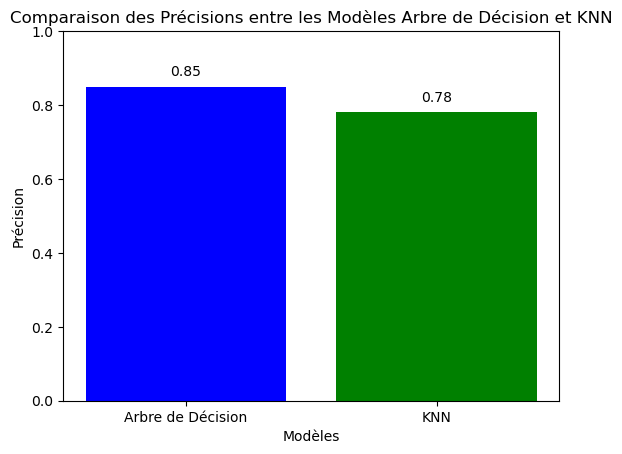

In [3]:
import matplotlib.pyplot as plt

# Précisions des deux modèles
decision_tree_accuracy = 0.85  # Exemple de précision de l'arbre de décision
knn_accuracy = 0.78  # Exemple de précision du modèle KNN

# Création des barres pour la comparaison
models = ['Arbre de Décision', 'KNN']
accuracies = [decision_tree_accuracy, knn_accuracy]

# Création du graphique
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Modèles')
plt.ylabel('Précision')
plt.title('Comparaison des Précisions entre les Modèles Arbre de Décision et KNN')
plt.ylim(0, 1)

# Affichage de la précision sur chaque barre
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom')

# Afficher le graphique
plt.show()

## Améliorations Arbre de Decision et KNN
##### .Pour améliorer nos modèles, nous avons nettoyé notre dataset en supprimant les doublons. Au début nous avions 1000 lignes de données, après le nettoyage du dataset,il nous reste alors 302 lignes ce qui a pu amélioré nos modèles.
##### .Pour améliorer les modèles, pour qu'ils puissent détecter efficacement les positions presque gagnées et presque perdues, on a besoin d'augmenter le volume des données.
##### .Optimiser les paramètres du 